# 1. 데어터 셋 구성하기

In [94]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [95]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

> 학습 이미지의 값을 -1, 1 사이로 정규화 해준다

In [96]:
train_x = (train_x - 127.5) / 127.5

print('max pixel : ', train_x.max())
print('min pixel : ', train_x.min())

max pixel :  1.0
min pixel :  -1.0


In [97]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

> 학습 이미지를 시각화를 통해 확인해보자.

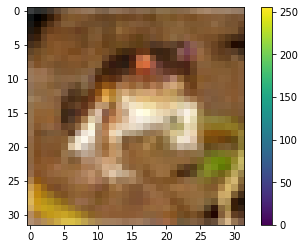

In [98]:
plt.imshow((train_x[0, :, :, :]*127.5 + 127.5).astype('uint8'))
plt.colorbar()
plt.show()

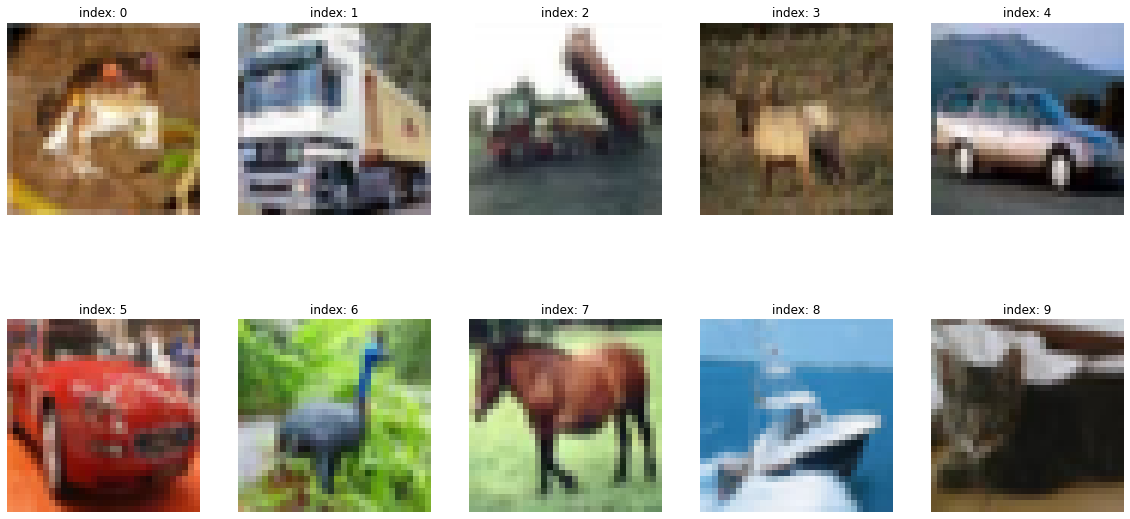

In [99]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i, :, :, :]*127.5 + 127.5).astype('uint8'))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

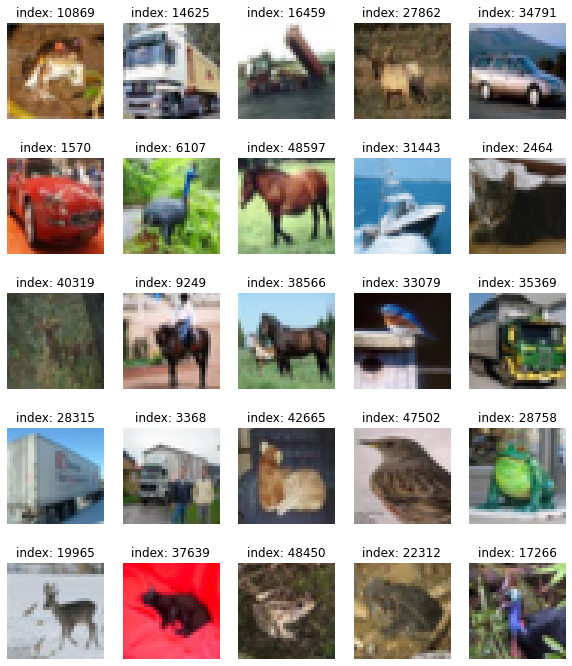

In [100]:
plt.figure(figsize=(10,12))

for i in range(25):
    num = np.random.randint(1, 50000)
    plt.subplot(5,5,i+1)
    plt.imshow((train_x[i, :, :, :]*127.5 + 127.5).astype('uint8'))
    plt.title(f'index: {num}')
    plt.axis('off')
plt.show()

> 편하게 사용할 수 있도록 텐서플로우의 Dateset을 이용해 준비해 놓자.
(모델에 넣을 떄 직접 섞어주지 않아도 된다.)

In [101]:
# 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.
BUFFER_SIZE = 50000 
BATCH_SIZE = 512

In [102]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 생성자 모델 구현하기

> 생성자 모델을 구현한다.   
> 기존 노드와 다른점은 각 층에 Dropout을 추가하여 Regularization 효과를 노렸고   
> BatchNormalization 에 momentum = 0.9 , LeakyReLu 에 alpha = 0.2 옵션을 주었다.   
> 또한 28,28,1 이미지에서 32, 32, 3 이미지로 변경되었기 때문에 파라미터를 변경해 주었다.

In [103]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    # Convolutional 연산을 할 수 있도록 1차원 벡터를 (4, 4, 512) 형상의 3차원 벡터로 변환시키는 작업
    model.add(layers.Reshape((4, 4, 512)))

    # Conv2DTranspos 층은 기존의 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다.
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU())
              
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [104]:
generator = make_generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 4, 4, 256)        

> 최종 출력에서 (32, 32, 3) 이 나온걸 확인할 수 있다.

> 랜덤 노이즈 벡터를 만들어 보자.

In [105]:
# 랜덤 벡터로 이루어진 노이즈 벡터
noise = tf.random.normal([1, 100])

In [106]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

> 첫 번째 1은 1개(batch_size=1)라는 뜻을 갖고, 그 뒤로 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻한다.

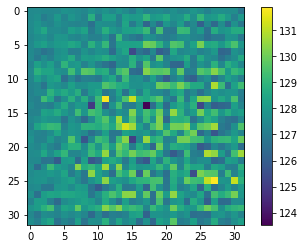

In [107]:
#plt.imshow((generated_image[0, :, :, :]*127.5 + 127.5).astype('uint8'))
plt.imshow((generated_image[0, :, :, 0]*127.5 + 127.5))
plt.colorbar()
plt.show()

> train을 안했기 때문에 아무 상관없는 랜덤 노이즈 벡터가 생성된다.

# 3. 판별자 구현하기

> 판별자를 구현해보자.   
> 기존 노드와 다른 점은 Dropout의 0.3으로 인자값을 줬고, input_shape 를 Cifar-10 데이터 셋의 이미지 사이즈에 맞는 32, 32, 3 으로 세팅 했다.

In [108]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [109]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

> 마지막 Flatten층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8*8*128=8192, 즉 (1, 8192) 형상의 벡터로 변환하였다.

In [110]:
decision = discriminator(generated_image, training=False)
                         
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.194855e-05]], dtype=float32)>

> 텐서플로우의 텐서 형태로 출력되었다. 이 값 또한 아직은 아무런 의미 없는 값이다.

# 4. 손실함수와 최적화 함수 구현하기

> 손실 함수로 Cross Entropy를 사용하였다.

In [111]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

> generator_loss는 fake_ouput이 1에 가까워지기를 바라므로, tf.ones_lie와 교차 엔트로피 값을 계산해야 된다.

In [112]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

> dicsrimator_loss는 fake_output 값은 0에, real_output 값은 1에 가까워지기를 바라므로 두가지 loss값을 모두 계산한 후    
> 최종 값은 두 값을 더한 값이다.

In [113]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

> GAN에서는 real_accuracy와 fake_accuracy가 둘다 0.5에 가까워 지는게 이상적이다.   
> 왜냐하면 둘 중 하나가 1에 가까워진다면 Generator가 이미지 생성을 잘못하고 있다고 판단할 수 있기 때문이다.

In [114]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [115]:
#  중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [116]:
# 샘플은 한 번에 16장을 생성하도록 하겠습니다.
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.
# 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 5. 훈련 과정 상세 기능 구현하기

In [117]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [118]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    try : 
        plt.savefig(os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
        plt.show()
    except:
        print('error')

In [119]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [120]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer = discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

# 6. 학습 시키기

In [121]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [122]:
save_every = 5
EPOCHS = 100

# 사용 가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

> 위에서 세팅한 모델로 훈련을 시작한다.

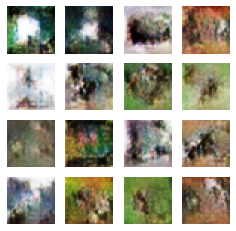

Time for training : 4256 sec


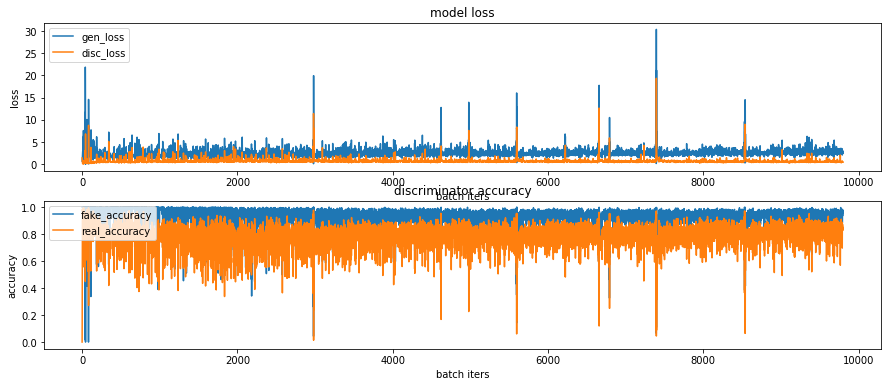

CPU times: user 1h 10min 47s, sys: 29.7 s, total: 1h 11min 17s
Wall time: 1h 10min 57s


In [123]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

> 위에서 설정한 체크포인트를 불러온다.

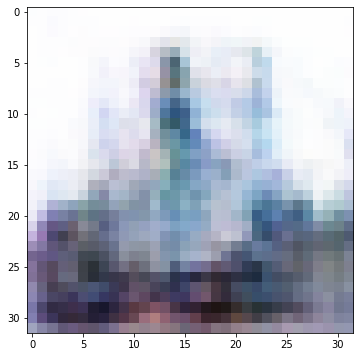

In [131]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 7. 훈련 과정 개선

## 기본
* Dataset
    * BATCH_SIZE = 256
* Adam
    * learning late = 0.0001
    * beta_1 = 0.9(default)
* Model
    * layers.Dropout()
    * layers.LeakyReLU()
    * layers.BatchNormalization()
* train
    * save_every = 5
    * EPOCHS = 100

In [82]:
anim_file = os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan_origin.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/generated_samples_origin/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        
!ls -l ~/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan_origin.gif

-rw-r--r-- 1 root root 1647241 Sep  2 13:21 /aiffel/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan_origin.gif


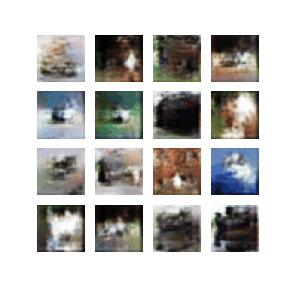

In [83]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan_origin.gif')

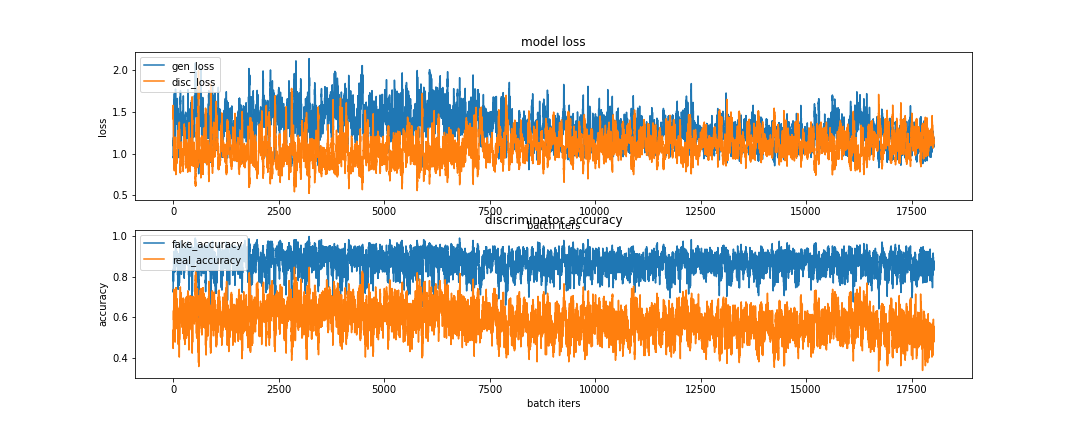

In [89]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/training_history_origin/train_history_0091.png')

> 이미지도 만족할만한 정도의 이미지가 생성(육안으로 어느정도의 구분) 되었고, real accuracy도 만족할만한 수치(0.5)로 나왔으나 face_accuracy가 만족스럽지 못하였다. 또한 generator/Discriminator loss도 좀처럼 줄지 않아 만족스럽지 못하였다.

## 개선 1

* DataSet
    * BATCH_SIZE = 256
* Adam
    * learning late = 0.0002
    * beta_1 = 0.5
* Model
    * layers.Dropout(0.3)
    * layers.LeakyReLU(alpha=0.2)
    * layers.BatchNormalization(momentum=0.9)
* train
    * save_every = 5
    * EPOCHS = 300

In [77]:
anim_file = os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        
!ls -l ~/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2338441 Sep  2 13:18 /aiffel/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif


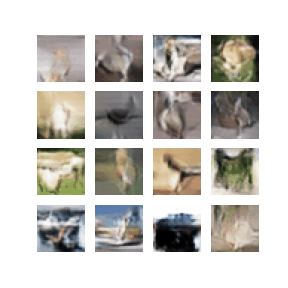

In [78]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif')

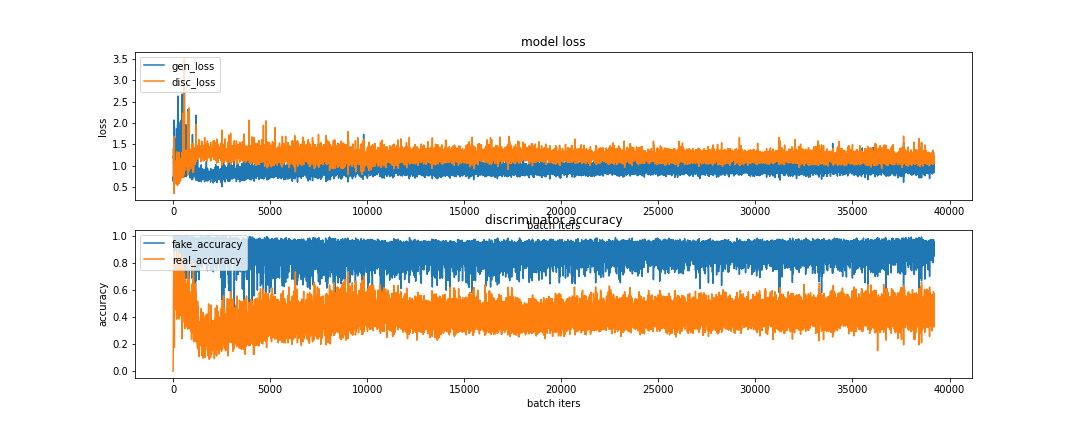

In [80]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/training_history/train_history_0199.png')

> 이미지도 만족할만한 정도의 이미지가 생성(육안으로 어느정도의 구분) 되었고, real accuracy도 만족할만한 수치(0.5)로 나왔으나 face_accuracy가 만족스럽지 못하였다. 또한 generator/Discriminator loss는 조금 줄어든 양상이 보이지만 썩 만족스럽지 못하였다.

## 개선 2

* DataSet
    * BATCH_SIZE = 512
* Adam
    * G learning late = 0.0001
    * D learning late = 0.001
    * beta_1 = 0.5
* Model
    * layers.Dropout(0.3)
    * layers.LeakyReLU(alpha=0.2)
    * layers.BatchNormalization(momentum=0.9)
    * 1 Layers Add
* train
    * save_every = 5
    * EPOCHS = 100

In [129]:
anim_file = os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/01_Exploration/E13/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        
!ls -l ~/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2404915 Sep  2 14:49 /aiffel/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan.gif


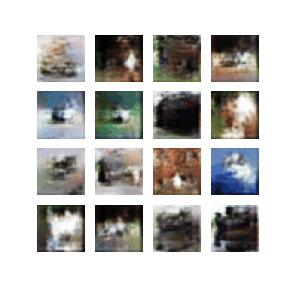

In [130]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/cifar10_dcgan_origin.gif')

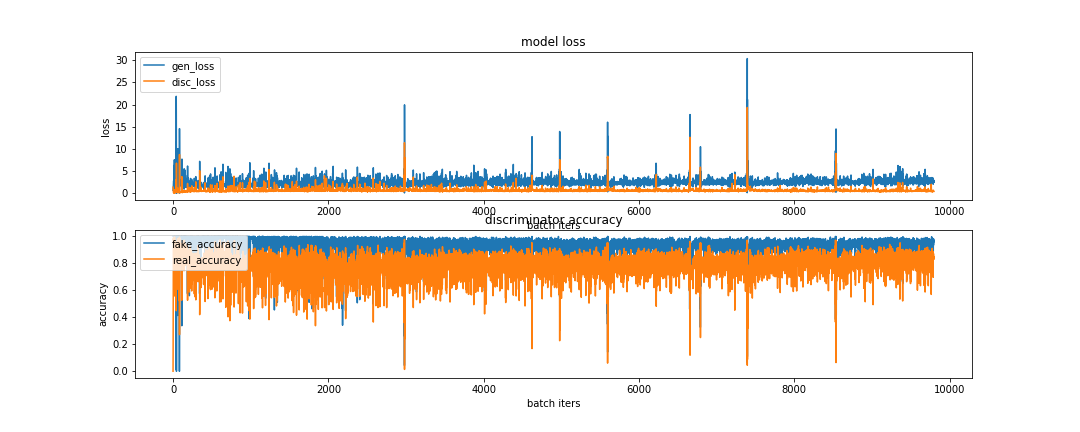

In [128]:
Image(os.getenv('HOME')+'/aiffel/01_Exploration/E13/cifar10/training_history/train_history_0099.png')

# 8. 회고

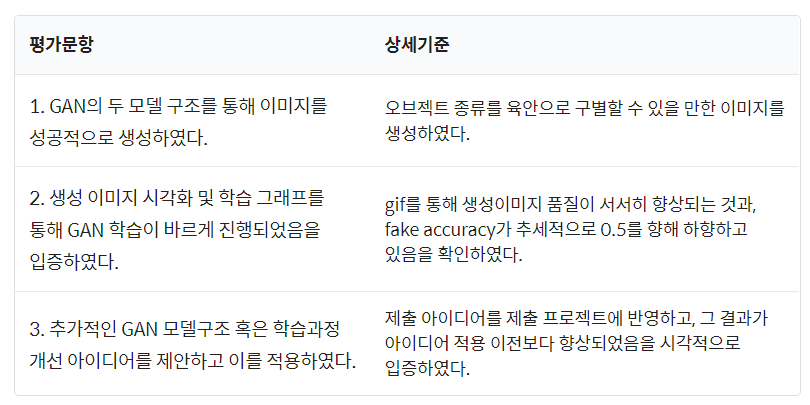

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

**😠 이번 프로젝트에서 어려웠던 점 :**   
GAN 모델의 생소함이다. GAN구현을 처음 접해보는 거라 개념을 이해하는데 오래 걸렸다. 또한 조원분들에게 조언을 얻은 결과 Epoch가 높아야 한다고 해서 진행하였는데, 학습시간이 너무 오래걸려 다른 시도를 많이 하지 못하였다.

**🤯 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한점 :**              
GAN에 대한 큰 그림은 알겠으나... 세부적으로 내용이 모호하다. 그러다보디 결과를 보고 어떤 파라미터를 변경하여 바로 잡을지를 몰라 시행착오를 너무 많이 느꼇다.

**🥴 루브릭 평가 지표를 맞추기 위해 시도한 것들 :**         
하이퍼 파라미터 변경등을 통해 최대한 만족할 만한 결과를 얻기 위하여 노력하였다.    
또한 생성자 모델을 층을 추가하거나 세부 파라미터 수정등을 하였다.


**😞만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정 :**    
fake accuracy 가 좀 처럼 줄어 들지 않았다.    
다른 분들 의견을 들었을 때 epoch를 거의 500번 1000번 해야 된다고 하였으나 시간상 하지못하여서 아쉽다.

**👊자기 다짐 :**              
노드 제출 기간이 끝나더라도 1000 epoch 이상을 진행하여 결과를 확인해보자. 또한 GAN에 대해 좀 더 깊이있게 알아보자.